# 주가 예측 프로젝트

###finance-datareader 라이브러리를 통한 데이터 수집

finance-datareader 설치

In [125]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


필요한 라이브러리 import

In [126]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt

카카오 주식 코드 = 035720

2020년 1월 1일부터 2022년 12월 10일까지의 데이터 다운로드

In [127]:
df = fdr.DataReader('035720', '2020-01-01', '2022-12-10')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,30909,31010,30508,30609,241047,-0.006524
2020-01-03,30810,31111,30308,30609,314848,0.000000
2020-01-06,30206,31109,30106,31010,393715,0.013101
2020-01-07,31110,32113,31009,32114,840186,0.035601
2020-01-08,31813,32516,31412,32014,851619,-0.003114


In [128]:
print(df.shape)

(728, 6)


###데이터 전처리

데이터 값의 범위를 줄이기 위해 MinMaxScaler 사용

In [129]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눈다
    return numerator / (denominator + 1e-7)

In [130]:
# Open - 시가, High - 고가, Low - 저가, Volume - 거래량, Close - 종가
dfx = df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
# 종가는 분리 -> 지도 학습에서 타겟 데이터로 사용하기 위함
dfy = dfx[['Close']]
dfx = dfx[['Open','High','Low','Volume']]
dfx

,Open,High,Low,Volume
Date,,,,
2020-01-02,0.179703,0.179249,0.189491,0.012757
2020-01-03,0.179128,0.179832,0.188248,0.016663
2020-01-06,0.175616,0.179821,0.186994,0.020837
2020-01-07,0.180872,0.185624,0.192602,0.044466
2020-01-08,0.184959,0.187954,0.195106,0.045071
...,...,...,...,...
2022-12-05,0.332558,0.341040,0.355280,0.108517
2022-12-06,0.333140,0.334682,0.347826,0.073082
2022-12-07,0.323837,0.327168,0.344099,0.053672


In [131]:
dfx.describe()

,Open,High,Low,Volume
count,728.000000,728.000000,728.000000,728.000000
mean,0.492679,0.497793,0.518208,0.105926
std,0.197967,0.199435,0.208354,0.112371
min,0.000000,0.000000,0.000000,0.000000
25%,0.349001,0.355723,0.369621,0.044262
50%,0.462163,0.468208,0.488696,0.080228
75%,0.633721,0.641618,0.660219,0.122243
max,1.000000,1.000000,1.000000,1.000000


In [132]:
dfy.head()

,Close
Date,
2020-01-02,0.026037
2020-01-03,0.026037
2020-01-06,0.028849
2020-01-07,0.036591
2020-01-08,0.035890


In [133]:
# 두 데이터를 리스트 형태로 저장
X = dfx.values.tolist()
y = dfy.values.tolist()

In [134]:
X[:5]

[[0.17970348837198855,
  0.1792485549131912,
  0.18949068322969598,
  0.012757084517146874],
 [0.17912790697664005,
  0.1798323699420926,
  0.188248447204852,
  0.01666290203178077],
 [0.17561627906966534,
  0.17982080924845098,
  0.18699378881975964,
  0.020836830703839838],
 [0.18087209302315066,
  0.1856242774565401,
  0.19260248447193007,
  0.04446570093020682],
 [0.18495930232547386,
  0.18795375722532487,
  0.19510559006199063,
  0.045070776899974296]]

In [135]:
y[:5]

[[0.026037137808177867],
 [0.026037137808177867],
 [0.028849120641756997],
 [0.03659083896662324],
 [0.035889596364733184]]

In [136]:
window_size = 10

# 공백 리스트 생성
data_X = []
data_y = []
for i in range(len(y) - window_size): # 데이터의 길이만큼 반복
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.32674418604632166, 0.3312138728321785, 0.3453416149066178, 0.07000633178422275], [0.32441860465097416, 0.3225433526009696, 0.3385093167699761, 0.07227209863611508], [0.3151162790695842, 0.324855491329292, 0.3360248447202882, 0.0719105772550706], [0.32325581395330044, 0.32601156069345316, 0.34223602484450794, 0.09663247940688215], [0.3441860465114278, 0.3445086705200321, 0.35838509316747924, 0.1532507181208628], [0.3366279069765485, 0.3369942196529844, 0.3534161490681035, 0.061707164188393435], [0.3325581395346904, 0.34104046242754854, 0.3552795031053694, 0.1085170118805097], [0.33313953488352727, 0.334682080924662, 0.3478260869563057, 0.07308156570141672], [0.32383720930213733, 0.32716763005761434, 0.34409937888177383, 0.053672085553391514], [0.32499999999981105, 0.3242774566472114, 0.34099378881966397, 0.0728701886854759]] -> [0.2188157414937738]


In [137]:
# 10일간의 OHLV 데이터
data_X[0]

[[0.17970348837198855,
  0.1792485549131912,
  0.18949068322969598,
  0.012757084517146874],
 [0.17912790697664005,
  0.1798323699420926,
  0.188248447204852,
  0.01666290203178077],
 [0.17561627906966534,
  0.17982080924845098,
  0.18699378881975964,
  0.020836830703839838],
 [0.18087209302315066,
  0.1856242774565401,
  0.19260248447193007,
  0.04446570093020682],
 [0.18495930232547386,
  0.18795375722532487,
  0.19510559006199063,
  0.045070776899974296],
 [0.19079069767430767,
  0.191999999999889,
  0.20257763975142698,
  0.04648383807313895],
 [0.19254651162779504,
  0.1931734104045126,
  0.20320496894397316,
  0.021270328234528665],
 [0.19312209302314354,
  0.19432369942185299,
  0.20569565217378527,
  0.025174028803584787],
 [0.1954534883719794,
  0.19547976878601417,
  0.20631677018620725,
  0.022401835645849282],
 [0.1948720930231425,
  0.19780346820797814,
  0.20756521739117542,
  0.024457019336392473]]

In [138]:
# data_X[0]을 넣었을 때의 정답인 data_y[0]
data_y[0]

[0.05277551821824579]

### 훈련 데이터와 테스트 데이터 분리

In [139]:
print('전체 데이터 크기 :', len(data_X), len(data_y))

전체 데이터 크기 : 718 718


In [140]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터 크기 :', test_X.shape, test_y.shape)

훈련 데이터 크기 : (502, 10, 4) (502, 1)
테스트 데이터 크기 : (216, 10, 4) (216, 1)


### 모델 학습

In [151]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [152]:
model = Sequential()
# input_shape(데이터길이, 입력 차원 숫자(n차원)) : LSTM에 들어갈 데이터 크기
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
# dropout : 모델을 학습시킬 때 오버피팅(overfitting)이 되는 것을 방지하는 방법
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 20)            2000      
                                                                 
 dropout_14 (Dropout)        (None, 10, 20)            0         
                                                                 
 lstm_15 (LSTM)              (None, 20)                3280      
                                                                 
 dropout_15 (Dropout)        (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


In [153]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=30)
pred_y = model.predict(test_X)

Epoch 1/70
17/17 [==============================] - 4s 10ms/step - loss: 0.2388
Epoch 2/70
17/17 [==============================] - 0s 10ms/step - loss: 0.0568
Epoch 3/70
17/17 [==============================] - 0s 11ms/step - loss: 0.0222
Epoch 4/70
17/17 [==============================] - 0s 11ms/step - loss: 0.0169
Epoch 5/70
17/17 [==============================] - 0s 11ms/step - loss: 0.0131
Epoch 6/70
17/17 [==============================] - 0s 12ms/step - loss: 0.0135
Epoch 7/70
17/17 [==============================] - 0s 10ms/step - loss: 0.0115
Epoch 8/70
17/17 [==============================] - 0s 10ms/step - loss: 0.0116
Epoch 9/70
17/17 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 10/70
17/17 [==============================] - 0s 10ms/step - loss: 0.0106
Epoch 11/70
17/17 [==============================] - 0s 11ms/step - loss: 0.0096
Epoch 12/70
17/17 [==============================] - 0s 11ms/step - loss: 0.0098
Epoch 13/70
17/17 [==================

### 주가 예측 & 시각화

7/7 [==============================] - 0s 4ms/step


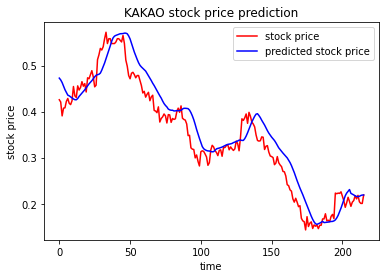

다음 날 KAKAO 주가 : [58119.273] KRW


In [154]:
pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red', label='stock price')
plt.plot(pred_y, color='blue', label='predicted stock price')
plt.title('KAKAO stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

print("다음 날 KAKAO 주가 :", df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')